# Классификатор комментариев 
(два класса: нежелательный, нормальный)

In [1]:
import pandas as pd
import numpy as np
import glob
import re
from datetime import datetime

np.random.seed(42)

In [2]:
df_comments = pd.read_csv('./labels/df_comments1228.csv', encoding='utf-8', header=0, sep='|', engine='python')
df_comments.drop(['comment_lower', 'validation_label'], axis=1, inplace=True)
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967704 entries, 0 to 967703
Data columns (total 4 columns):
Resource        967704 non-null object
comment         967704 non-null object
Publish Date    967704 non-null object
label           42315 non-null float64
dtypes: float64(1), object(3)
memory usage: 29.5+ MB


In [3]:
df_comments.label.value_counts()

0.0    26074
1.0    16241
Name: label, dtype: int64

# Train/test split
Разделяю базу комментариев на train/test (размеченная часть) и unsup (неразмеченные)

In [4]:
from sklearn.model_selection import train_test_split

abuse_comments = df_comments.loc[df_comments.label == 1]['comment']
common_comments = df_comments.loc[df_comments.label == 0]['comment']
unsup_comments = df_comments.loc[df_comments.label.isnull()]['comment']

#unsup_comments = unsup_comments.sample(frac=0.6) # иначе memory error при обучении doc2vec

#use 1 for abuse comments, 0 for common comments
y = np.concatenate((np.ones(len(abuse_comments)), np.zeros(len(common_comments))))

x_train, x_test, y_train, y_test = train_test_split(np.concatenate((abuse_comments, common_comments)), y, test_size=0.2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(unsup_comments.shape)

(33852,)
(8463,)
(33852,)
(8463,)
(925389,)


# Подготавливаю тексты для Doc2Vec
Предобработка за счет исключения лишних символов/ слов и лемматизации слов позволяет сократить словарь для Doc2Vec, что положительно влияет на точность итоговой модели

In [5]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
import re

def cleanText(corpus, lemmatize=True, dropStopwords=True, dropPunctuation=True):
    
    stem = Mystem()
    http_match = 'http[s]?://(?:[a-zA-Zа-яА-Я]|[0-9]|[$-_@.&#+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    email_match = '[a-z.-]+@[a-z.-]{4,}'
    
    corpus = [z.lower().replace('\n',' ') for z in corpus]
    corpus = [z.replace('<br />', ' ') for z in corpus]
    corpus = [z.replace('ё', 'е') for z in corpus]
    corpus = [z.replace('\ufeff', '') for z in corpus]
    corpus = [re.sub(http_match, 'link', z) for z in corpus] #заменяю ссылки на 'Link'
    corpus = [re.sub(email_match, 'email', z) for z in corpus] #заменяю e-mail на 'email'
    corpus = [re.sub('[0-9]', ' ', z) for z in corpus]
    
    if dropPunctuation:
        corpus = [re.sub("[^а-яА-Яa-zA-Z]"," ", z) for z in corpus] #заменяю пунктуацию на пробелы
    else:
        punctuation = """.,?!:;(){}[]"""
        for c in punctuation:
            corpus = [z.replace(c, ' %s '%c) for z in corpus] #выделяю пунктуацию в отдельные слова
                  
    corpus = [z.split() for z in corpus]
    
    if dropStopwords: #удаляю английские и русские стопслова
        russian_stopwords = stopwords.words("russian")
        stopwords_extension = ['ко']
        russian_stopwords = russian_stopwords + stopwords_extension
        stopwords_exclusion = ['не', 'нет', 'нельзя']
        for word in stopwords_exclusion:
            russian_stopwords.remove(word)
        stops = set(stopwords.words("english")) | set(russian_stopwords)
        for i, z in enumerate(corpus):
            corpus[i] = [w for w in corpus[i] if not w in stops]  
    
    if lemmatize: #лемматизация
        for i, z in enumerate(corpus):
            for j, w in enumerate(z):
                corpus[i][j] = stem.lemmatize(w)[0]
    return corpus

In [6]:
%%time
x_train = cleanText(x_train)
x_test = cleanText(x_test)
unsup_comments = cleanText(unsup_comments)

CPU times: user 8min 6s, sys: 1min 26s, total: 9min 33s
Wall time: 22min 31s


In [7]:
# Реализация Doc2Vec в Gensim требует, чтобы каждый документ имел ассоциированную с ним метку
# Для данного преобразования в Gensim предусмотрен метод TaggedDocument
# Все комментарии конкатенируются и им проставляются метки

import gensim
TaggedDocument = gensim.models.doc2vec.TaggedDocument

def labelizeComments(comments, label_type):
    labelized = []
    for i, v in enumerate(comments):
        label = '%s_%s'%(label_type,i)
        labelized.append(TaggedDocument(v, [label]))
    return labelized

x = labelizeComments(np.concatenate((x_train, x_test, unsup_comments)), 'ALL')

In [8]:
x[:2]

[TaggedDocument(words=['ебать', 'й', 'америка', 'черножопый', 'растреливать', 'улица', 'бесить', 'собака'], tags=['ALL_0']),
 TaggedDocument(words=['огромный', 'спасибо', 'ребята', 'супер', 'молодец', 'обнимать', 'ура', 'ура', 'урааааааааааааааааа', 'россия'], tags=['ALL_1'])]

# Doc2Vec
Позволяет посчитать вектора одинаковой длины для текстов различной длины.
Обучаю 2 модели Doc2Vec на полной выборке предобработанных текстов. 
По результатам формирую по два вектора длиной 400 для каждого комментария выборки. 
Вектора двух моделей были соединены горизонтально (horizintal stack), что и является итоговыми векторами текстов длиной 800.

In [9]:
SIZE = 400

# ДЛЯ ОБУЧЕНИЯ DOC2VEC:
# WORKERS = 4
# EPOCHS = 55

# #instantiate our DM and DBOW models
# model_dm = gensim.models.doc2vec.Doc2Vec(min_count=3, window=8, seed=42, vector_size=SIZE, sample=1e-3, negative=5, workers=WORKERS, epochs=EPOCHS)
# model_dbow = gensim.models.doc2vec.Doc2Vec(min_count=3, window=8, seed=42, vector_size=SIZE, sample=1e-3, negative=5, dm=0, workers=WORKERS, epochs=EPOCHS)

# #build vocab over all comments
# model_dm.build_vocab(x)
# model_dbow.build_vocab(x)

# ДЛЯ ЗАГРУЗКИ ПРЕДОБУЧЕННОГО DOC2VEC:
model_dm = gensim.models.doc2vec.Doc2Vec.load('./doc2vec/doc2vec_dm_596874.model')
model_dbow = gensim.models.doc2vec.Doc2Vec.load('./doc2vec/doc2vec_dbow_596874.model')

In [10]:
# %%time
# ДЛЯ ОБУЧЕНИЯ DOC2VEC:
# print('training model_dm...')
# model_dm.train(x, total_examples=model_dm.corpus_count, epochs=model_dm.epochs)

# print('training model_dbow...')
# model_dbow.train(x, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

#Get vectors from our models
# def getVecs(model, corpus, size):
#     vecs = [np.array(model[z.tags[0]]).reshape((1, SIZE)) for z in corpus]
#     return np.concatenate(vecs)

# vecs_dm = getVecs(model_dm, x, SIZE)
# vecs_dbow = getVecs(model_dbow, x, SIZE)

# vecs = np.hstack((vecs_dm, vecs_dbow))
# print(vecs.shape)

# x_train_vecs = vecs[:len(x_train)]
# x_test_vecs = vecs[len(x_train):(len(x_train) + len(x_test))]

In [11]:
%%time
# ДЛЯ ЗАГРУЖЕННОГО ПРЕДОБУЧЕННОГО DOC2VEC:
def getNewVecs(model, corpus, size):
    vecs = [np.array(model.infer_vector(z, steps=150, alpha=0.025).reshape((1, size))) for z in corpus]
    return np.concatenate(vecs)

x_train_vecs_dm = getNewVecs(model_dm, x_train, SIZE)
x_train_vecs_dbow = getNewVecs(model_dbow, x_train, SIZE)
x_train_vecs = np.hstack((x_train_vecs_dm, x_train_vecs_dbow))
print('x_train: {}, x_train_vecs: {}'.format(len(x_train), x_train_vecs.shape))

x_test_vecs_dm = getNewVecs(model_dm, x_test, SIZE)
x_test_vecs_dbow = getNewVecs(model_dbow, x_test, SIZE)
x_test_vecs = np.hstack((x_test_vecs_dm, x_test_vecs_dbow))
print('x_test: {}, x_test_vecs: {}'.format(len(x_test), x_test_vecs.shape))

x_train: 33852, x_train_vecs: (33852, 800)
x_test: 8463, x_test_vecs: (8463, 800)
CPU times: user 25min 23s, sys: 0 ns, total: 25min 23s
Wall time: 25min 24s


# Обучаю модели
При помощи gridsearch с кроссвалидацией подбираю оптимальные параметры модели SGDClassifier

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(n_jobs=-1)

params_grid = {
    'loss': ['hinge'],
    'alpha': [0.000001, 0.00001, 0.0001],
    'penalty': ['l1', 'l2'],
    'max_iter': [30, 40, 50],
    'learning_rate': ['constant', 'optimal'],
    'eta0': [0.001, 0.01, 0.1]
}

gs = GridSearchCV(clf, param_grid=params_grid, scoring='f1',verbose=3, cv=4, n_jobs=-1)
gs.fit(x_train_vecs, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
[CV] alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1 
[CV] alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1 
[CV] alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1 
[CV] alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1, score=0.9106922126081582, total=   9.0s
[CV] alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1, score=0.9147022332506204, total=   9.3s
[CV] alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1, score=0.9175960346964065, total=   

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min


[CV]  alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.91, total=  10.2s
[CV] alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.9069373942470389, total=  10.3s
[CV] alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.9075917859365277, total=  10.2s
[CV] alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.9038521766363922, total=  10.1s
[CV] alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.911616547092047, total=   4.1s


[CV] alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2, score=0.9229098805646037, total=   4.9s
[CV] alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2, score=0.920684292379471, total=   5.5s
[CV] alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.9229323308270677, total=  14.9s
[CV] alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.9190778276342255, total=  15.9s
[CV] alpha=1e-06, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-06, eta0=0.0

[CV]  alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1, score=0.9199937372788477, total=  10.4s
[CV] alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.9169009684473602, total=   3.5s
[CV] alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.9206153846153847, total=   3.8s
[CV] alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.9084745762711864, total=   3.1s
[CV] alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.9216108207808177, total=  

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.9min


[CV]  alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.9112099371262078, total=   9.2s
[CV] alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.902988652708966, total=  10.8s
[CV] alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1, score=0.9048329355608592, total=   9.6s
[CV] alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.9151030452168563, total=   3.9s
[CV] alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-06, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.9082248332804065, total=   4.0s
[CV]

[CV] alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2, score=0.9184909175593852, total=   5.4s
[CV] alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2, score=0.9153918201685919, total=   5.5s
[CV] alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.9177570093457944, total=  16.0s
[CV] alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.921146398140976, total=  16.4s
[CV]  alpha=1e-05, eta0=0.001, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.913568773

[CV]  alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1, score=0.919696735262262, total=  10.4s
[CV] alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.9188020994133991, total=   3.7s
[CV] alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.922142634693242, total=   3.9s
[CV] alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.9218965781801444, total=   4.3s
[CV] alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.919802590993214, to

[CV] alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.9180887372013652, total=  15.8s
[CV] alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.9173073905538992, total=  16.7s
[CV] alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2, score=0.9150512214342001, total=   6.2s
[CV] alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.9149425287356322, total=  16.6s
[CV] alpha=1e-05, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l1 
[CV]  alpha=1e-05, eta0=0.01, learn

[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.9211722300579847, total=   3.7s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1, score=0.9127369575434748, total=  13.4s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1, score=0.9150062266500623, total=  13.8s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1, score=0.9167449139280125, total=  14.4s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=o

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 11.1min


[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.9147996213316504, total=  16.0s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.9159900062460963, total=  16.8s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.915737298636927, total=  15.8s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l1, score=0.9139801855637678, total=  15.4s
[CV] alpha=1e-05, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=1e-05, eta0=0.1, learning_rate=op

[CV] alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.921644685802948, total=   3.3s
[CV] alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.9219550038789759, total=   4.0s
[CV]  alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l2, score=0.9252900232018563, total=   4.3s
[CV] alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1 
[CV] alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l1, score=0.9131451738655855, total=  12.3s
[CV] alpha=0.0001, eta0=0.001, learning_rate=optimal, loss=hinge, max_iter=40, penalty=l2 
[CV]  alpha=0.0001

[CV] alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2, score=0.9190108191653786, total=   6.2s
[CV] alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.9178908303695686, total=  17.4s
[CV] alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2 
[CV]  alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l1, score=0.9213099487816234, total=  18.2s
[CV] alpha=0.0001, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1 
[CV]  alpha=0.0001, eta0=0.01, learning_rate=constant, loss=hinge, max_iter=50, penalty=l2, score=0.9222830336200156, total=   6.0s
[CV] alpha=0.0001, eta0=0.01, learning_rate=optimal, loss=hinge, max_iter=30, penalty=l1 
[CV]  alpha=0.0001,

[CV]  alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=30, penalty=l2, score=0.918469739730323, total=   4.3s
[CV] alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1 
[CV]  alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1, score=0.9139886578449906, total=  13.9s
[CV]  alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1, score=0.920171937365674, total=  13.5s
[CV] alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2 
[CV] alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2 
[CV]  alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1, score=0.9170953101361573, total=  14.0s
[CV] alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l2 
[CV]  alpha=0.0001, eta0=0.1, learning_rate=constant, loss=hinge, max_iter=40, penalty=l1, score=0.9196121363778542, t

[CV]  alpha=0.0001, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2, score=0.9251785159888234, total=   5.4s
[CV]  alpha=0.0001, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2, score=0.9209504581456748, total=   5.0s
[CV]  alpha=0.0001, eta0=0.1, learning_rate=optimal, loss=hinge, max_iter=50, penalty=l2, score=0.9218798630563336, total=   5.9s


[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 17.3min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['hinge'], 'alpha': [1e-06, 1e-05, 0.0001], 'penalty': ['l1', 'l2'], 'max_iter': [30, 40, 50], 'learning_rate': ['constant', 'optimal'], 'eta0': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=3)

In [13]:
gs.best_params_

{'alpha': 1e-05,
 'eta0': 0.01,
 'learning_rate': 'constant',
 'loss': 'hinge',
 'max_iter': 50,
 'penalty': 'l1'}

In [14]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(alpha=0.00001, eta0=0.01, learning_rate='constant', loss='hinge', penalty='l1', max_iter=50, verbose=1, n_jobs=-1)
sgdc.fit(x_train_vecs, y_train)

print('Test Accuracy: %.4f'%sgdc.score(x_test_vecs, y_test))

-- Epoch 1
Norm: 9.86, NNZs: 793, Bias: -0.080000, T: 33852, Avg. loss: 0.271484
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 12.08, NNZs: 792, Bias: -0.080000, T: 67704, Avg. loss: 0.183686
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 13.56, NNZs: 785, Bias: -0.270000, T: 101556, Avg. loss: 0.169037
Total training time: 0.52 seconds.
-- Epoch 4
Norm: 14.72, NNZs: 778, Bias: -0.180000, T: 135408, Avg. loss: 0.161595
Total training time: 0.68 seconds.
-- Epoch 5
Norm: 15.64, NNZs: 774, Bias: -0.110000, T: 169260, Avg. loss: 0.156632
Total training time: 0.88 seconds.
-- Epoch 6
Norm: 16.41, NNZs: 776, Bias: -0.110000, T: 203112, Avg. loss: 0.153370
Total training time: 1.05 seconds.
-- Epoch 7
Norm: 17.10, NNZs: 780, Bias: -0.090000, T: 236964, Avg. loss: 0.150885
Total training time: 1.21 seconds.
-- Epoch 8
Norm: 17.72, NNZs: 775, Bias: -0.150000, T: 270816, Avg. loss: 0.148740
Total training time: 1.37 seconds.
-- Epoch 9
Norm: 18.29, NNZs: 769, Bias: -0.320000, T: 3046

In [15]:
import seaborn as sns
from sklearn.metrics import *
from matplotlib import pyplot as plt
%matplotlib inline

predictions = sgdc.predict(x_test_vecs)
print(classification_report(y_test, predictions, digits=4))

             precision    recall  f1-score   support

        0.0     0.9465    0.9558    0.9511      5183
        1.0     0.9291    0.9146    0.9218      3280

avg / total     0.9398    0.9399    0.9398      8463



In [16]:
labels = sgdc.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

# Проверка на новых данных
Проверяю на случайно выбранных из неразмеченных ранее данных 201 комментарии. Классы для данной выборки были проставлены вручную

In [17]:
df_val = pd.read_csv('./labels/new_validation_set.csv', encoding='utf-8', header=0, sep='|', engine='python')
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 2 columns):
comment    201 non-null object
label      201 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB


In [22]:
#Get vectors for validation set
x_val = cleanText(df_val.comment)

def getNewVecs(model, corpus, size):
    vecs = [np.array(model.infer_vector(z, steps=150, alpha=0.025).reshape((1, size))) for z in corpus]
    return np.concatenate(vecs)

val_vecs_dm = getNewVecs(model_dm, x_val, SIZE)
val_vecs_dbow = getNewVecs(model_dbow, x_val, SIZE)

x_val_vecs = np.hstack((val_vecs_dm, val_vecs_dbow))
# x_val_vecs = val_vecs_dm
y_val = df_val.label
print(x_val_vecs.shape)
print(y_val.shape)

(201, 800)
(201,)


Accuracy: 0.8010
             precision    recall  f1-score   support

        0.0     0.9660    0.8023    0.8765       177
        1.0     0.3519    0.7917    0.4872        24

avg / total     0.8927    0.8010    0.8301       201



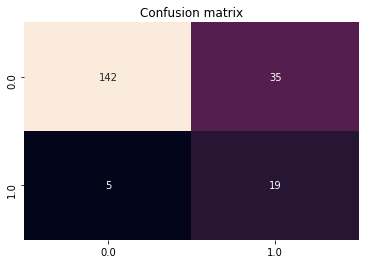

In [23]:
predictions = sgdc.predict(x_val_vecs)
print("Accuracy: {0:6.4f}".format(accuracy_score(y_val, predictions)))
print(classification_report(y_val, predictions, digits=4))
labels = sgdc.classes_
sns.heatmap(data=confusion_matrix(y_val, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

In [29]:
pd.options.display.max_colwidth = 120
df_val['predictions'] = predictions
df_val.loc[(df_val.label == df_val.predictions) & (df_val.label == 1)].head(10)

comment  \
20                                    Главное, что бы на украинском не выпускали, вернее на фашистском, бандеровском языке.   
24                   а что ты сам не станешь илоном маском? Дебил, да? хорошо хоть есть на кого подрочить,ущербный ты наш.﻿   
30  Alexander Chukhalenko\nТак это Путин тебя нагнул и впихнул? \nИзвиняюсь, сначала нагнул, а потом впихнул? \nИли снач...   
36                                                                                         Пидарасам на капоте самое место﻿   
38                                                                                       Стала из неё вульгарная бабища....   
39                                                      путинское правительство за что не бралось всё просрало или украло!﻿   
42                                                                                            говно ваш Летов. левый утырок   
44                                                                        Да не нохчи это никакой,а провокатор хохложопый.﻿   
48                                                                                                       Мочить надо чурок﻿   
79                                              Мюнхаузен! вернись в сказку и засунь свой язык народному кандидату в попу.﻿   

    label  predictions  
20    1.0          1.0  
24    1.0          1.0  
30    1.0          1.0  
36    1.0          1.0  
38    1.0          1.0  
39    1.0          1.0  
42    1.0          1.0  
44    1.0          1.0  
48    1.0          1.0  
79    1.0          1.0

In [30]:
df_val.loc[(df_val.label == df_val.predictions) & (df_val.label == 0)].head(10)

comment  \
0                                                                                                                      test   
1                                                                                                   Безмозглая субстанция!﻿   
2   Вся суть в том, что в России такую статью можно написать про кого угодно из "илит". Вот смотрите, разве не органично...   
3                                                                          Другими словами: Platz und halt die Fresse!! ;D﻿   
5                                                                                                     Конец печальный ))))﻿   
6                                                                                                он на японца похож,бедный!   
7                                                                              Подождать с поездками в Барселону, временно.   
8   Ученик - это будущее, не испорченное системой и имеющее своё мнение, которое подавляется, не успев развиться! Это он...   
9                                        Из грузчиков прямо в экс-президенты. Талант кухарки - умение держать нос по ветру.   
10                                                                               Вася Орлов , сынуля , мне уже больше 40 !﻿   

    label  predictions  
0     0.0          0.0  
1     0.0          0.0  
2     0.0          0.0  
3     0.0          0.0  
5     0.0          0.0  
6     0.0          0.0  
7     0.0          0.0  
8     0.0          0.0  
9     0.0          0.0  
10    0.0          0.0

In [31]:
df_val.loc[~(df_val.label == df_val.predictions) & (df_val.label == 1)].head(10)

comment  \
11                                                       Окончательная победа будет после завоевания или уничтожения  США.﻿   
67  Страшная страна хуже гитлеровской Германии. Кегебе это тоже гестапо только еще более зверское. Этот презикдент отрав...   
73                                                                                     время детонации укрятских пердачков﻿   
77  Эвоно как старается, как у него душа болит! Мы все ему ещё скажем "Пошёл ты нахуй со своим регулированием интернета!...   
99  Vladimir Vasiliev иди помолись святым мощам. Я  тут уже начитался ебланов, сил нет. Путин, только Путин может и долж...   

    label  predictions  
11    1.0          0.0  
67    1.0          0.0  
73    1.0          0.0  
77    1.0          0.0  
99    1.0          0.0

In [32]:
df_val.loc[~(df_val.label == df_val.predictions) & (df_val.label == 0)].head(10)

comment  \
4                                                                                                            0:16 facepalm﻿   
14                                              Ну да, умственно отсталому меньше слов бы не помешало. Обычный вор и все...   
15                ща пойдем поскачем как не скоты (майдауны) и тогда заживем ))))))) рiволюцiя дастоинства млять))))))))))﻿   
17                                                                                          И тут Госдеп уже подсуетился...   
18                                                              Валентина К Почему ложь и клевета? Может самой шоры снять?﻿   
45                                                                                     Azino 777 великая США)))))ты пиндос﻿   
47  Пока на Украине герой бандера и шухевичь мира с ними не будет! И Ковалёв не ошибся а просто предатель! Не будет друж...   
52                                                     Пиндосы, вперед в школу, учить новое слово - ПАРИТЕТ! Да, нас рать!﻿   
54                                                                        Есть поговорка  Спешишь  Европу влитиш В жопу )))   
58  Путин Вам не врёт? А где его дети живут? Путин сделал своё дело, Путин должен уходить.\nЗа Грудинина!\nИ не путать Г...   

    label  predictions  
4     0.0          1.0  
14    0.0          1.0  
15    0.0          1.0  
17    0.0          1.0  
18    0.0          1.0  
45    0.0          1.0  
47    0.0          1.0  
52    0.0          1.0  
54    0.0          1.0  
58    0.0          1.0

In [20]:
# # сохранить обученный doc2vec:
# model_dm.save('./doc2vec/doc2vec_dm_596874.model')
# model_dbow.save('./doc2vec/doc2vec_dbow_596874.model')